In [20]:
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

iris = load_iris(as_frame=True)
df = iris.frame
df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [21]:
y = df["target"]
X = df.drop(columns='target')
X.head()



,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [23]:
pd.DataFrame(X_scaled, columns=X.columns).head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


In [24]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

feature_names = ["sepal length (cm)", "sepal width (cm)",
                 "petal length (cm)", "petal width (cm)"]

# PCA à 2 composantes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
components = pca.components_
explained = pca.explained_variance_ratio_

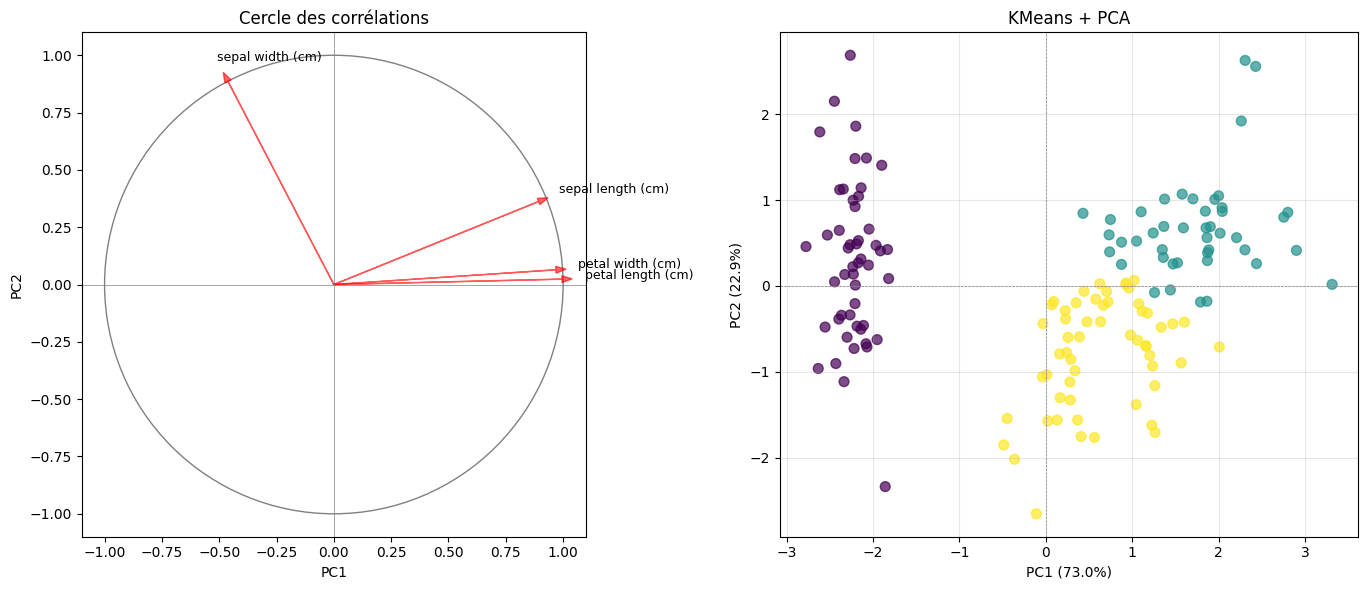

In [25]:

# Cercle des corrélations
correlations = components.T * np.sqrt(pca.explained_variance_)

# KMeans (sur les données standardisées)
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(X_scaled)

# Affichage côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ➤ A. Cercle des corrélations
ax1.set_xlim(-1.1, 1.1)
ax1.set_ylim(-1.1, 1.1)
ax1.set_aspect('equal')
ax1.set_title("Cercle des corrélations")
ax1.axhline(0, color='grey', lw=0.5)
ax1.axvline(0, color='grey', lw=0.5)
circle = plt.Circle((0, 0), 1, color='grey', fill=False)
ax1.add_artist(circle)

for i in range(correlations.shape[0]):
    ax1.arrow(0, 0, correlations[i, 0], correlations[i, 1],
              color='red', alpha=0.6, head_width=0.03)
    ax1.text(correlations[i, 0]*1.1, correlations[i, 1]*1.1,
             feature_names[i], fontsize=9)

ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")

# ➤ B. Projection PCA avec KMeans
ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
ax2.set_title("KMeans + PCA")
ax2.set_xlabel(f"PC1 ({explained[0]*100:.1f}%)")
ax2.set_ylabel(f"PC2 ({explained[1]*100:.1f}%)")
ax2.axhline(0, color='grey', linestyle='--', linewidth=0.5)
ax2.axvline(0, color='grey', linestyle='--', linewidth=0.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


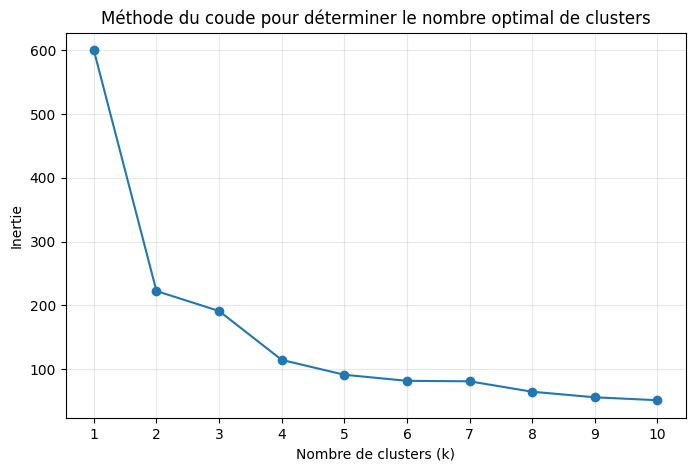

In [26]:


# Calcul de l'inertie pour k = 1 à 10
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)  # Attention : utiliser les données standardisées
    inertias.append(kmeans.inertia_)

# Affichage du graphe du coude
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Méthode du coude pour déterminer le nombre optimal de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.show()


In [27]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index (ARI) : {ari:.2f}")


Adjusted Rand Index (ARI) : 0.59


In [28]:
from sklearn.metrics import confusion_matrix
import pandas as pd

pd.crosstab(y, labels, rownames=["Classe réelle"], colnames=["Cluster"])


Cluster,0,1,2
Classe réelle,,,
0,50,0,0
1,0,11,39
2,0,33,17


In [29]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(X_scaled, labels)
print(f"Silhouette Score : {silhouette:.2f}")


Silhouette Score : 0.46


In [30]:
## KMeans from scratch

In [31]:
import numpy as np

class KMeansSimple:
    def __init__(self, k=3, max_iters=100, random_state=42):
        self.k = k
        self.max_iters = max_iters
        self.random_state = random_state

    def fit(self, X):
        np.random.seed(self.random_state)
        self.X = X
        self.n_samples, self.n_features = X.shape

        # Initialiser les centres aléatoirement parmi les points
        indices = np.random.choice(self.n_samples, self.k, replace=False)
        self.centroids = X[indices]

        for _ in range(self.max_iters):
            # Étape 1 : assigner chaque point au centre le plus proche
            distances = self._compute_distances(X)
            self.labels = np.argmin(distances, axis=1)

            # Étape 2 : recalculer les centres
            new_centroids = np.array([
                X[self.labels == i].mean(axis=0) if len(X[self.labels == i]) > 0 else self.centroids[i]
                for i in range(self.k)
            ])

            # Vérifier la convergence
            if np.allclose(self.centroids, new_centroids, rtol=1e-4):
                break

            self.centroids = new_centroids

    def predict(self, X):
        distances = self._compute_distances(X)
        return np.argmin(distances, axis=1)

    def _compute_distances(self, X):
        # Matrice des distances : chaque ligne = point, chaque colonne = centre
        return np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)


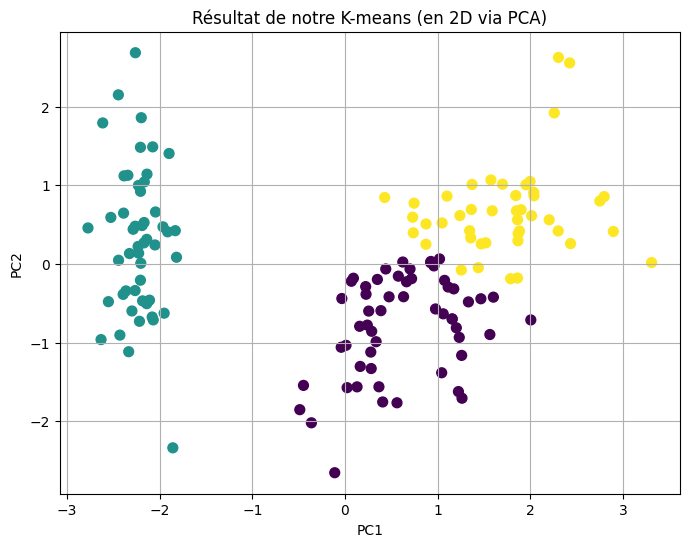

In [32]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Données
iris = load_iris()
X = iris.data

# Standardiser
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means from scratch
kmeans = KMeansSimple(k=3)
kmeans.fit(X_scaled)
labels = kmeans.labels

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.title("Résultat de notre K-means (en 2D via PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

